In [1]:
import pandas as pd
import numpy as np
import re
import jieba as jb
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score,classification_report,accuracy_score
from sklearn.svm import LinearSVC


data = pd.read_excel('附件2.xlsx')
print(data.shape)
data = data.drop(["留言时间","留言用户"],axis=1)


(9210, 6)


In [25]:
#判断是否有空值
print("在留言详情列中总共有 %d 个空值." % data['留言详情'].isnull().sum())
print("在标签列中总共有 %d 个空值." % data['一级标签'].isnull().sum())

#统计各类别的数量
d = {'一级标签':data['一级标签'].value_counts().index, 'count': data['一级标签'].value_counts()}
cf_counts = pd.DataFrame(d).reset_index(drop=True)
# print(d)

#将一级分类标签转化为相应数字,方便后续建模训练
data['tag'] = data['一级标签'].factorize()[0]
data['tag'].count()
# print(data['tag'])

#将数据整合标签对应的数据并储存
tags = data[['一级标签', 'tag']].drop_duplicates().sort_values('tag').reset_index(drop=True)
tags_to_id = dict(tags.values)
id_to_tags = dict(data[['tag', '一级标签']].values)
print(tags_to_id)
print(id_to_tags)
data.sample(5)

在留言详情列中总共有 0 个空值.
在标签列中总共有 0 个空值.
{'城乡建设': 0, '环境保护': 1, '交通运输': 2, '教育文体': 3, '劳动和社会保障': 4, '商贸旅游': 5, '卫生计生': 6}
{0: '城乡建设', 1: '环境保护', 2: '交通运输', 3: '教育文体', 4: '劳动和社会保障', 5: '商贸旅游', 6: '卫生计生'}


,留言编号,留言主题,留言详情,一级标签,tag,clean_data,cut_clean_data
49,6116,A市住房公积金政策毫无执行力,\n\t\t\t\t\t\n\t\t\t\t\tA市住房公积金管理中心于2016年7月28日...,城乡建设,0,A市住房公积金管理中心于2016年7月28日出台了A市住房公积金个人住房组合贷款管理办法意在...,A 市 住房 公积金 管理中心 2016 年 月 28 日 出台 A 市 住房 公积金 个人...
2844,161711,反映京珠高速1499公里两侧环境污染问题,\n\t\t\t\t\t\n\t\t\t\t\t 京珠高速是我国一条非常重要的高速公路，全...,环境保护,1,京珠高速是我国一条非常重要的高速公路全国各地的车辆都有经过我每天开车经过京珠高速经常发现京珠...,京珠 高速 我国 一条 非常 重要 高速公路 全国 各地 车辆 每天 开车 京珠 高速 经常...
5781,98178,A7县供电分公司星沙供电所管理混乱，农民工维权难,\n \n 农民工维权怎么这样难？ 《中化人民共和国劳动合同法》已由中...,劳动和社会保障,4,农民工维权怎么这样难中化人民共和国劳动合同法已由中华人民共和国第十届全国人民代表大会常务委员...,农民工 维权 难 中化 人民共和国 劳动 合同法 中华人民共和国 第十届 全国人民代表大会常...
8424,32669,试问D市附一王燕医生的医德何在？,\n \n 我的女儿今年1岁9个月，2012年6月1号晚上有点发烧37....,卫生计生,6,我的女儿今年1岁9个月2012年6月1号晚上有点发烧379家人给用了退热贴跟感冒药后烧退了到...,女儿 今年 岁 月 2012 年 月 号 晚上 有点 发烧 379 家人 退热 贴 感冒药 ...
118,13692,A市公共汽车大多要2元，老百姓承受不起！,\n\t\t\t\t\t\n\t\t\t\t\t 老百姓就是一只蚂蚁，公交公司想取消线路就...,城乡建设,0,老百姓就是一只蚂蚁公交公司想取消线路就取消想涨价就涨价就不考虑这可是关系到我们老百姓每天的生...,老百姓 一只 蚂蚁 公交公司 想 取消 线路 取消 想 涨价 涨价 考虑 关系 老百姓 每天...


In [3]:
#定义删除除语句中字母,数字，汉字函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line

#过滤语句中字母，数字，汉字函数
data['clean_data'] = data['留言详情'].apply(remove_punctuation)
print(data['clean_data'][:1])

#加载停用词汇
filepath = "StopWords.txt"
stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]

#语句使用滤停用词
data['cut_clean_data'] = data['clean_data'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
data

Building prefix dict from the default dictionary ...


0    A3区大道西行便道未管所路口至加油站路段人行道包括路灯杆被圈西湖建筑集团燕子山安置房项目施工...
Name: clean_data, dtype: object


Dumping model to file cache C:\Users\lyh\AppData\Local\Temp\jieba.cache
Loading model cost 0.699 seconds.
Prefix dict has been built successfully.


,留言编号,留言主题,留言详情,一级标签,tag,clean_data,cut_clean_data
0,24,A市西湖建筑集团占道施工有安全隐患,\n\t\t\t\t\t\n\t\t\t\t\tA3区大道西行便道，未管所路口至加油站路段，...,城乡建设,0,A3区大道西行便道未管所路口至加油站路段人行道包括路灯杆被圈西湖建筑集团燕子山安置房项目施工...,A3 区 大道 西行 便道 未管 路口 加油站 路段 人行道 包括 路灯 杆 圈 西湖 建筑...
1,37,A市在水一方大厦人为烂尾多年，安全隐患严重,\n\t\t\t\t\t\n\t\t\t\t\t位于书院路主干道的在水一方大厦一楼至四楼人为...,城乡建设,0,位于书院路主干道的在水一方大厦一楼至四楼人为拆除水电等设施后烂尾多年用护栏围着不但占用人行道...,位于 书院 路 主干道 在水一方 大厦 一楼 四楼 人为 拆除 水电 设施 烂尾 多年 护栏...
2,83,投诉A市A1区苑物业违规收停车费,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的领导：A1区苑小区位于A1区火炬路，小...,城乡建设,0,尊敬的领导A1区苑小区位于A1区火炬路小区物业A市程明物业管理有限公司未经小区业主同意利用业...,尊敬 领导 A1 区苑 小区 位于 A1 区 火炬 路 小区 物业 A 市程明 物业管理 有...
3,303,A1区蔡锷南路A2区华庭楼顶水箱长年不洗,\n\t\t\t\t\t\n\t\t\t\t\tA1区A2区华庭小区高层为二次供水，楼顶水箱...,城乡建设,0,A1区A2区华庭小区高层为二次供水楼顶水箱长年不洗现在自来水龙头的水严重霉味大家都知道水是我...,A1 区 A2 区华庭 小区 高层 二次 供水 楼顶 水箱 长年 不洗 现在 自来水 龙头 ...
4,319,A1区A2区华庭自来水好大一股霉味,\n\t\t\t\t\t\n\t\t\t\t\tA1区A2区华庭小区高层为二次供水，楼顶水箱...,城乡建设,0,A1区A2区华庭小区高层为二次供水楼顶水箱长年不洗现在自来水龙头的水严重霉味大家都知道水是我...,A1 区 A2 区华庭 小区 高层 二次 供水 楼顶 水箱 长年 不洗 现在 自来水 龙头 ...
...,...,...,...,...,...,...,...
9205,11763690,两孩子一个是一级脑瘫，能再生育吗？,\n \n 我们夫妻都是农村户口，大的是女9岁，小的是儿2岁半，才15斤...,卫生计生,6,我们夫妻都是农村户口大的是女9岁小的是儿2岁半才15斤治疗两年一级脑瘫我是纯女户招郎男方两兄...,夫妻 农村户口 女 岁 岁 半才 15 斤 治疗 两年 一级 脑瘫 纯 女户 招郎 男方 两...
9206,11977590,B市中心医院医生不负责任，做无痛人流手术后结果还是活胚芽,\n \n 本人2015年2月16号在B市中心医院做无痛人流手术，手术后...,卫生计生,6,本人2015年2月16号在B市中心医院做无痛人流手术手术后还有怀孕的症状于2015年2月25...,2015 年 月 16 号 B 市中心 医院 做 无痛 人流 手术 手术 怀孕 症状 201...
9207,14697490,西地省二胎产假新政策何时出台？,\n \n 我们是再婚，很想再要一个小孩，不知我省二胎新政策何时出，如果...,卫生计生,6,我们是再婚很想再要一个小孩不知我省二胎新政策何时出如果先怀孕了会做和处理,再婚 想 一个 小孩 不知 我省 二胎 新 政策 出 先 怀孕 会 做 处理
9208,15397690,K8县惊现奇葩证明！,\n \n K8县惊现奇葩证明！ 我是西地省K8县人，想生二孩。被告知要...,卫生计生,6,K8县惊现奇葩证明我是西地省K8县人想生二孩被告知要开证明即没生二孩的证明先写好证明找村计生...,K8 县惊现 奇葩 证明 西地省 K8 县人想 生二孩 告知 要开 证明 没 生二孩 证明 ...


In [3]:
#生成新表将数据保存
data.to_csv('first_clean_data.csv',encoding="utf_8_sig")
data.head(5)

,留言编号,留言主题,留言详情,一级标签,tag
0,24,A市西湖建筑集团占道施工有安全隐患,\n\t\t\t\t\t\n\t\t\t\t\tA3区大道西行便道，未管所路口至加油站路段，...,城乡建设,0
1,37,A市在水一方大厦人为烂尾多年，安全隐患严重,\n\t\t\t\t\t\n\t\t\t\t\t位于书院路主干道的在水一方大厦一楼至四楼人为...,城乡建设,0
2,83,投诉A市A1区苑物业违规收停车费,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的领导：A1区苑小区位于A1区火炬路，小...,城乡建设,0
3,303,A1区蔡锷南路A2区华庭楼顶水箱长年不洗,\n\t\t\t\t\t\n\t\t\t\t\tA1区A2区华庭小区高层为二次供水，楼顶水箱...,城乡建设,0
4,319,A1区A2区华庭自来水好大一股霉味,\n\t\t\t\t\t\n\t\t\t\t\tA1区A2区华庭小区高层为二次供水，楼顶水箱...,城乡建设,0


['城乡建设' '环境保护' '交通运输' '教育文体' '劳动和社会保障' '商贸旅游' '卫生计生']


KeyError: 7

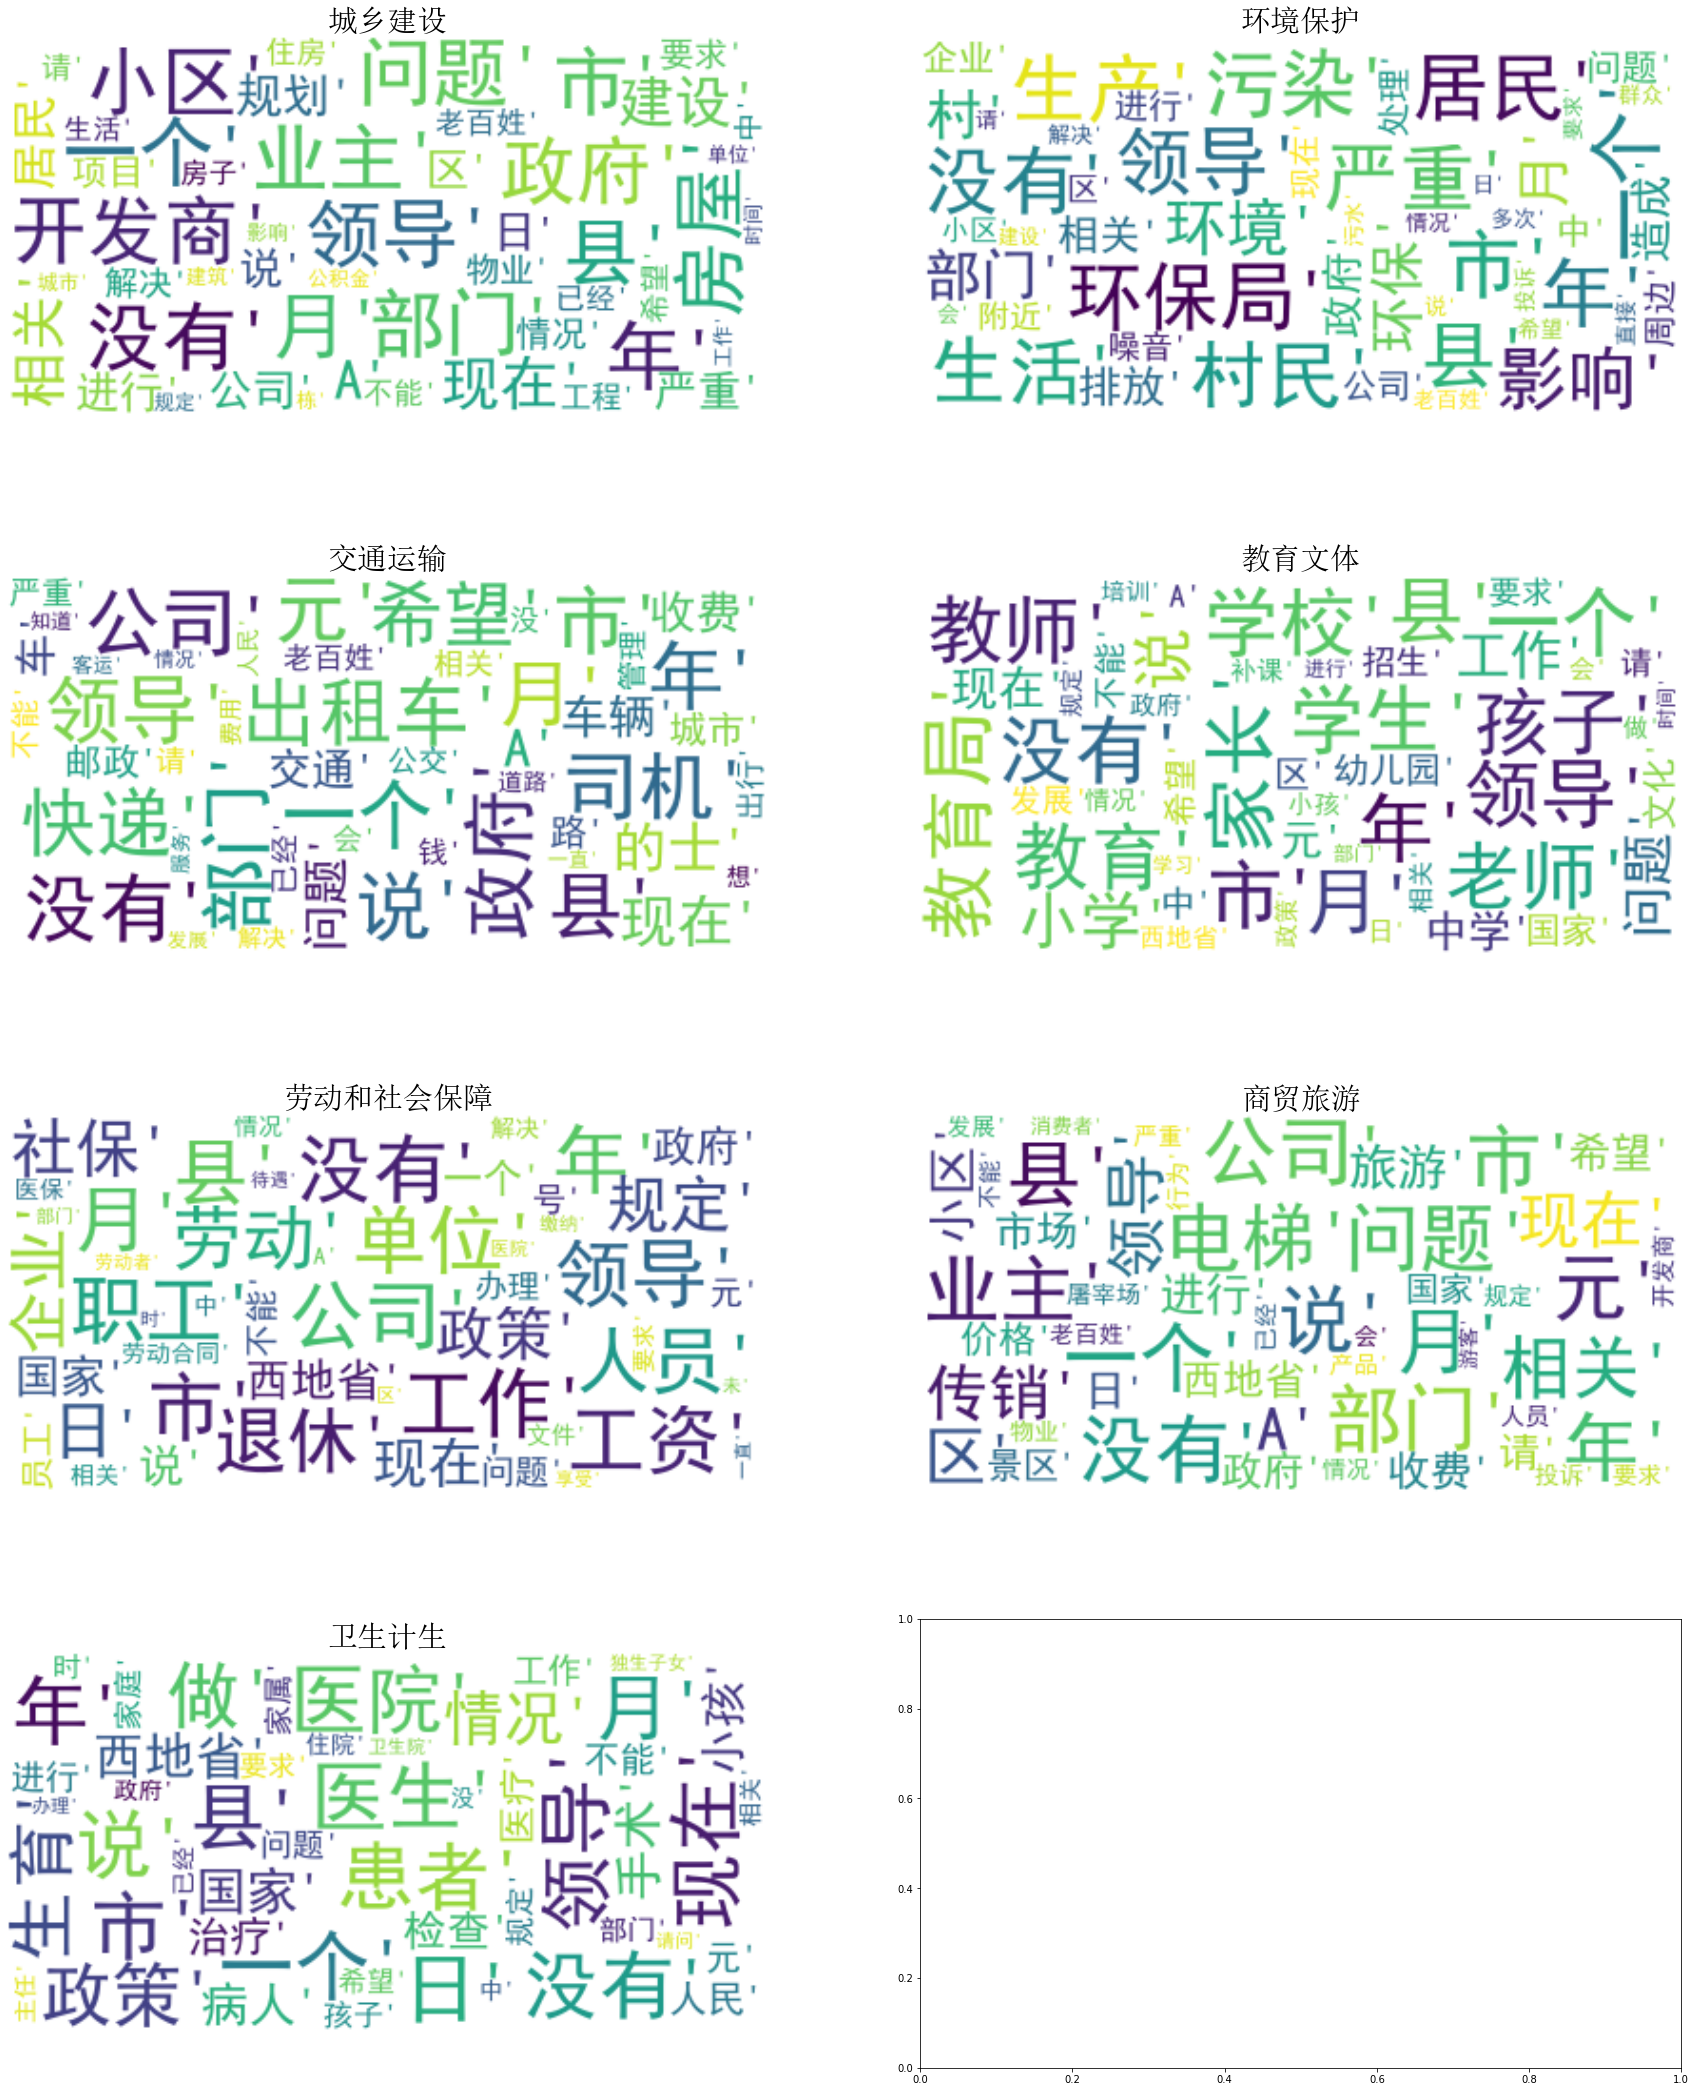

In [9]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)

def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          font_path='simhei.ttf',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud
 
tag_desc = dict()
print(tags['一级标签'].values)
for tag in tags['一级标签'].values: 
    
    text = data.loc[data['一级标签']==tag, 'cut_clean_data']
    text = (' '.join(map(str,text))).split(' ')
    tag_desc[tag]=text
    
# print(tag_desc)
# print(data['一级标签']==tag)
    
fig,axes = plt.subplots(4, 2, figsize=(30, 38))
k=0
for i in range(4):
    for j in range(2):
        div_tag = id_to_tags[k]
        most50=Counter(tag_desc[div_tag]).most_common(50)
        ax = axes[i, j]
        ax.imshow(generate_wordcloud(most50), interpolation="bilinear")
        ax.axis('off')
        ax.set_title(div_tag,fontproperties=font_set, fontsize=30)
        k+=1


In [10]:
#data为数据集,划分为80%训练集和20%测试集
x_train, x_test, y_train, y_test = train_test_split(data['cut_clean_data'],data['tag'], test_size = 0.2)

#对CountVectorizer进行初始化，生成词频向量
vect = CountVectorizer().fit(x_train)
x_train_vect = vect.transform(x_train)
x_test_vect = vect.transform(x_test)

#列表呈现生成的词频向量词典
#print(count_vect.get_feature_names())
#print(count_vect.vocabulary_)

#生成TF-IDF特征向量
tfidf = TfidfTransformer(smooth_idf = False)
x_train_tfidf = tfidf.fit_transform(x_train_vect)
x_test_tfidf = tfidf.transform(x_test_vect)
print(x_train_tfidf.shape)

#训练LinearSVC分类器
clf = LinearSVC().fit(x_train_tfidf,y_train)
#预测测试集结果
y_predict = clf.predict(x_test_tfidf)

# F-Score对分类方法进行评价
f1 = f1_score(y_test,y_predict,average='weighted')
print('F1值为',f1)
print('正确率',accuracy_score(y_test,y_predict))

(7368, 72692)
F1值为 0.9076140448613467
正确率 0.9077090119435396


In [9]:
# 测试结果
print("------------")
print("对结果集进行测试")
print("------------")
data_test = pd.read_excel('result/附件2（测试数据）.xlsx')
data_test['留言详情'] = data_test['留言详情'].apply(remove_punctuation)
data_test['cut_clean_data'] = data_test['留言详情'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
data_test

,留言编号,留言用户,留言主题,留言时间,留言详情,一级分类,cut_clean_data
0,1,U0001196,投诉A市A1区苑物业违规收停车费,2019/12/30 17:06:14,尊敬的领导A1区苑小区位于A1区火炬路小区物业A市程明物业管理有限公司未经小区业主同意利用业...,NaN,尊敬 领导 A1 区苑 小区 位于 A1 区 火炬 路 小区 物业 A 市程明 物业管理 有...
1,23,U0002738,A4区五一大道一酒吧噪音严重影响居民休息,2020/1/6 13:15:56,位于五一大道202的李四的LISTPUB天天在晚上十点钟之后到其营业时间凌晨三四点钟结束都大...,NaN,位于 五一 大道 202 李四 LISTPUB 天天 晚上 十点钟 之后 营业时间 凌晨 三...
2,26,U0003729,A市地铁6号线桐梓坡地铁站交叉口低频率噪音严重扰民,2020/1/6 11:29:11,近2个月来地铁6号线桐梓坡地铁站交叉口有设备发出怪异的低频率噪音严重扰民日夜不停整个附近小区...,NaN,近 月 地铁 号线 桐梓 坡 地铁站 交叉口 设备 发出 怪异 低 频率 噪音 严重 扰民 ...
3,39,U0007638,A市地铁8号线工作现在就要开始准备了,2020/1/3 22:26:19,今年地铁3号线和5号线通车后正线就只剩下6号线在修如果今年开始启动7号线到2022年6号线通...,NaN,今年 地铁 号线 号线 通车 正线 剩下 号线 修 今年 启动 号线 2022 年 号线 通...
4,40,U0005855,A2区福满新城二期施工噪音扰民谁能管,2020/1/3 20:08:05,今天是投诉A2区福满新城二期噪音扰民问题第82天以前天天拨打12345投诉奢望能引起市政府职...,NaN,今天 投诉 A2 区福满 新城 二期 噪音 扰民 问题 82 天 以前 天天 拨打 1234...
...,...,...,...,...,...,...,...
2796,6056990,U0004035,为何在B市乡镇卫生院的高级职工所在的点不能一视同仁还保留？,2012/12/15 18:39:45,我想请问一下领导自从乡村医生实行基药开始是不是所有的乡镇卫生院底下的各村驻点都撤了为何在卫生...,NaN,想 请问 一下 领导 乡村 医生 实行 基药 是不是 乡镇 卫生院 底下 各村 驻点 撤 卫...
2797,6665290,U0008214,C3县居民这样的情况要不要罚款？,2011/12/13 14:05:17,你好我是C3县居民在家中是独女父亲是老师母亲是农民在农村居住读中专时户口转到了C市区在05年...,NaN,你好 C3 县 居民 家中 独女 父亲 老师 母亲 农民 农村 居住 读 中专 时 户口 转...
2798,16704000,U0007689,请求市长查处步步高E12市店长期拖欠员工加班工资的违法行为,2011/11/16 1:35:27,尊敬的王书记您好步步高E12市店无视劳动法有关规定国家法定节假日上班14小时却不发或者少发加...,NaN,尊敬 王 书记 您好 步步高 E12 市店 无视 劳动法 规定 国家 法定 节假日 上班 1...
2799,33681565,U0006759,B市滨江花园二期容积率达到4.11之高,2018/12/24 19:19:26,西地省格尚置业有限公司于2004年取得滨江花园一期的土地出让合同并办理了土地使用证面积为13...,NaN,西地 省格尚 置业 有限公司 2004 年 取得 滨江 花园 一期 土地出让 合同 办理 土...


In [14]:
len(data_test['cut_clean_data'])

2801

In [13]:
#data为数据集,划分为80%训练集和20%测试集
# x_train, x_test, y_train, y_test = train_test_split(data['cut_clean_data'],data['tag'], test_size = 0.2)

x_train = data['cut_clean_data']
y_train = data['tag']
x_test = data_test['cut_clean_data']

#对CountVectorizer进行初始化，生成词频向量
vect = CountVectorizer().fit(x_train)
x_train_vect = vect.transform(x_train)
x_test_vect = vect.transform(x_test)

#列表呈现生成的词频向量词典
#print(count_vect.get_feature_names())
#print(count_vect.vocabulary_)

#生成TF-IDF特征向量
tfidf = TfidfTransformer(smooth_idf = False)
x_train_tfidf = tfidf.fit_transform(x_train_vect)
x_test_tfidf = tfidf.transform(x_test_vect)
print(x_train_tfidf.shape)

#训练LinearSVC分类器'
clf = LinearSVC().fit(x_train_tfidf,y_train)
#预测测试集结果
y_predict = clf.predict(x_test_tfidf)

len(y_predict)

# F-Score对分类方法进行评价
# f1 = f1_score(y_test,y_predict,average='weighted')
# print('F1值为',f1)
# print('正确率',accuracy_score(y_test,y_predict))

(9210, 80847)


array([0, 0, 1, ..., 4, 0, 3], dtype=int64)

In [30]:
data_test['一级分类'] = y_predict
# data_test.to_csv('result_test.csv',encoding="utf_8_sig")
data_test

,留言编号,留言用户,留言主题,留言时间,留言详情,一级分类,cut_clean_data
0,1,U0001196,投诉A市A1区苑物业违规收停车费,2019/12/30 17:06:14,尊敬的领导A1区苑小区位于A1区火炬路小区物业A市程明物业管理有限公司未经小区业主同意利用业...,0,尊敬 领导 A1 区苑 小区 位于 A1 区 火炬 路 小区 物业 A 市程明 物业管理 有...
1,23,U0002738,A4区五一大道一酒吧噪音严重影响居民休息,2020/1/6 13:15:56,位于五一大道202的李四的LISTPUB天天在晚上十点钟之后到其营业时间凌晨三四点钟结束都大...,0,位于 五一 大道 202 李四 LISTPUB 天天 晚上 十点钟 之后 营业时间 凌晨 三...
2,26,U0003729,A市地铁6号线桐梓坡地铁站交叉口低频率噪音严重扰民,2020/1/6 11:29:11,近2个月来地铁6号线桐梓坡地铁站交叉口有设备发出怪异的低频率噪音严重扰民日夜不停整个附近小区...,1,近 月 地铁 号线 桐梓 坡 地铁站 交叉口 设备 发出 怪异 低 频率 噪音 严重 扰民 ...
3,39,U0007638,A市地铁8号线工作现在就要开始准备了,2020/1/3 22:26:19,今年地铁3号线和5号线通车后正线就只剩下6号线在修如果今年开始启动7号线到2022年6号线通...,0,今年 地铁 号线 号线 通车 正线 剩下 号线 修 今年 启动 号线 2022 年 号线 通...
4,40,U0005855,A2区福满新城二期施工噪音扰民谁能管,2020/1/3 20:08:05,今天是投诉A2区福满新城二期噪音扰民问题第82天以前天天拨打12345投诉奢望能引起市政府职...,1,今天 投诉 A2 区福满 新城 二期 噪音 扰民 问题 82 天 以前 天天 拨打 1234...
...,...,...,...,...,...,...,...
2796,6056990,U0004035,为何在B市乡镇卫生院的高级职工所在的点不能一视同仁还保留？,2012/12/15 18:39:45,我想请问一下领导自从乡村医生实行基药开始是不是所有的乡镇卫生院底下的各村驻点都撤了为何在卫生...,6,想 请问 一下 领导 乡村 医生 实行 基药 是不是 乡镇 卫生院 底下 各村 驻点 撤 卫...
2797,6665290,U0008214,C3县居民这样的情况要不要罚款？,2011/12/13 14:05:17,你好我是C3县居民在家中是独女父亲是老师母亲是农民在农村居住读中专时户口转到了C市区在05年...,6,你好 C3 县 居民 家中 独女 父亲 老师 母亲 农民 农村 居住 读 中专 时 户口 转...
2798,16704000,U0007689,请求市长查处步步高E12市店长期拖欠员工加班工资的违法行为,2011/11/16 1:35:27,尊敬的王书记您好步步高E12市店无视劳动法有关规定国家法定节假日上班14小时却不发或者少发加...,4,尊敬 王 书记 您好 步步高 E12 市店 无视 劳动法 规定 国家 法定 节假日 上班 1...
2799,33681565,U0006759,B市滨江花园二期容积率达到4.11之高,2018/12/24 19:19:26,西地省格尚置业有限公司于2004年取得滨江花园一期的土地出让合同并办理了土地使用证面积为13...,0,西地 省格尚 置业 有限公司 2004 年 取得 滨江 花园 一期 土地出让 合同 办理 土...


In [32]:
print(id_to_tags)
data_test['一级分类'] = data_test['一级分类'].map(id_to_tags)
data_test

{0: '城乡建设', 1: '环境保护', 2: '交通运输', 3: '教育文体', 4: '劳动和社会保障', 5: '商贸旅游', 6: '卫生计生'}


In [40]:
data_result = pd.read_excel('result/附件2（测试结果）.xlsx')
data_result['一级分类'] = y_predict
data_result['一级分类'] = data_result['一级分类'].map(id_to_tags)
data_result.to_excel('result/附件2（测试结果）.xlsx',encoding="utf_8_sig")